In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

import cesm_orcas_sci as cesm
import cam
import gv

import colorbrewer

import pandas
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004'
obs,mdl = gv.open_flightdata(case,mask=True)
mdl.info()

/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
earth_geometry.py:57: RuntimeWarning: invalid value encountered in less_equal
  mask = np.array((haversine(clon,clat,plon.ravel(),plat.ravel()) <= range_km))
gv.py:48: RuntimeWarning: invalid value encountered in less
  land_mask = ~( (points_in_range(airport_lon,airport_lat,x,y,10.)) & (z < 4.) )
gv.py:51: RuntimeWarning: invalid value encountered in greater_equal
  region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )
gv.py:51: RuntimeWarning: invalid value encountered in less_equal
  region_mask = ( (lat_rgn[0] <= y) & (y <= lat_rgn[1]) & (lon_rgn[0] <= x) & (x <= lon_rgn[1]) )


xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		CO2_T09c:long_name = Takahashi

In [3]:
tracer_def = cesm.trace_gas_tracers(case)
tracer_3d = [k for k in tracer_def]

ds = cesm.open_casedata(case,'atm','cam.h0',tracer_3d+['SF'+v for v in tracer_3d if 'IDL' not in v],transformed='so_ocean_mean')

ds = cesm.convert_dataset(ds,case)
ds = ds.isel(zlev=np.where(ds.zlev < 15e3)[0])
ds.CO2_OCN.attrs['long_name'] = 'CESM'
ds

<xarray.Dataset>
Dimensions:     (time: 3347, zlev: 33)
Coordinates:
  * zlev        (zlev) float64 1.416e+04 1.315e+04 1.212e+04 1.107e+04 ...
  * time        (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Data variables:
    O2_OCN      (time, zlev) float64 8.963 8.99 9.111 9.818 11.27 13.62 ...
    CO2_CROF    (time, zlev) float64 4.6 4.807 5.156 5.605 5.989 6.223 6.297 ...
    CO2_LND     (time, zlev) float64 0.3145 0.3642 0.5007 0.6551 0.7804 ...
    CO2_T09     (time, zlev) float64 -0.7934 -0.8375 -0.9395 -1.106 -1.29 ...
    CO2_T09a    (time, zlev) float64 -0.7796 -0.823 -0.9232 -1.086 -1.265 ...
    CO2_T09b    (time, zlev) float64 -0.7665 -0.8095 -0.9094 -1.073 -1.254 ...
    CO2_T09c    (time, zlev) float64 -0.7865 -0.8302 -0.9314 -1.096 -1.277 ...
    CO2_T09d    (time, zlev) float64 -0.78 -0.8235 -0.9245 -1.089 -1.272 ...
    CO2_T09e    (time, zlev) float64 -0.8002 -0.8447 -0.9476 -1.116 -1.303 ...
    CO2_T09f    (time, zlev) float64 -0.8068 -0.8514 -0.9545 -

total area = 5.1008244881083744e+14
check area = 5.1009969907076156e+14


/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


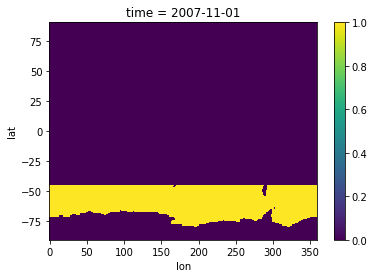

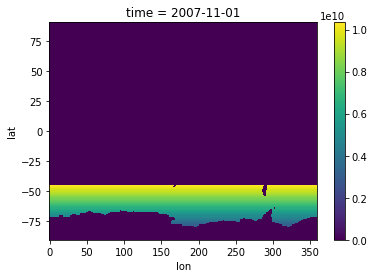

In [4]:
grid = xr.open_dataset('./data/f09_f09.nc')
landfrac = grid.LANDFRAC.isel(time=0)
area = grid_tools.compute_grid_area(grid.lon.values,grid.lat.values)
rmask = landfrac.where(landfrac<0.9).fillna(0.).where(landfrac>=0.9).fillna(1.).where(landfrac.lat<-44.).fillna(0.)
plt.figure()
rmask.plot()
area = rmask * area
plt.figure()
area.plot()

### compute region integral of fluxes (from avg)

In [5]:
co2_ocn = ['CO2_T09', 'CO2_L14C',
           'CO2_T09a', 'CO2_T09b', 'CO2_T09c', 
           'CO2_T09d', 'CO2_T09e', 'CO2_T09f', 'CO2_T09g', 
           'CO2_T09h', 'CO2_T09i', 'CO2_T09j', 'CO2_T09k', 
           'CO2_T09l','CO2_OCN']
#           'CO2_CRPO', 'CO2_CROO', 'CO2_C15O']

sfint = xr.Dataset()
for v in co2_ocn:
    sfint[v] = ds['SF'+v] * area.sum() * 12.e-15
    sfint[v].attrs['units'] = 'Pg C yr$^{-1}$'

### compute vertical gradient

In [6]:
#lower_trop = np.array([0,2000.])
#upper_trop = np.array([3000,4000.])

lower_trop = np.array([2000.,3000.])
upper_trop = np.array([5000,6000.])


nx_lower_trop = np.where((lower_trop[0]<=ds.zlev)&(ds.zlev<=lower_trop[1]))[0]
nx_upper_trop = np.where((upper_trop[0]<=ds.zlev)&(ds.zlev<=upper_trop[1]))[0]
vg_bins = np.concatenate((lower_trop,upper_trop))


compute vertical gradient from model regional mean

In [7]:
vg = ds.groupby_bins('zlev',vg_bins).mean(dim='zlev')
vg = vg.isel(zlev_bins=0) - vg.isel(zlev_bins=-1)
vg.info()

xarray.Dataset {
dimensions:
	time = 3347 ;

variables:
	datetime64[ns] time(time) ;
		time:long_name = time ;
		time:bounds = time_bnds ;
	float64 O2_OCN(time) ;
	float64 CO2_CROF(time) ;
	float64 CO2_LND(time) ;
	float64 CO2_T09(time) ;
	float64 CO2_T09a(time) ;
	float64 CO2_T09b(time) ;
	float64 CO2_T09c(time) ;
	float64 CO2_T09d(time) ;
	float64 CO2_T09e(time) ;
	float64 CO2_T09f(time) ;
	float64 CO2_T09g(time) ;
	float64 CO2_T09h(time) ;
	float64 CO2_T09i(time) ;
	float64 CO2_T09j(time) ;
	float64 CO2_T09k(time) ;
	float64 CO2_T09l(time) ;
	float64 CO2_OCN(time) ;
	float64 CO2_CROT(time) ;
	float64 CO2_L14C(time) ;
	float64 CO2_CRPO(time) ;
	float64 CO2_CROL(time) ;
	float64 CO2_CROO(time) ;
	float64 aO2_GKA(time) ;
	float64 O2_GKA(time) ;
	float64 CO2_C15T(time) ;
	float64 CO2(time) ;
	float64 CO2_FFF(time) ;
	float64 IDL_T000(time) ;
	float64 IDL_T001(time) ;
	float64 IDL_T002(time) ;
	float64 IDL_T003(time) ;
	float64 IDL_T004(time) ;
	float64 IDL_T005(time) ;
	float64 IDL_T006

Observed vertical gradient

In [8]:
vg_obs = obs.groupby_bins('GGALT',vg_bins*1e-3).mean()
vg_mdl = mdl.groupby_bins('GGALT',vg_bins*1e-3).mean()

vg_obs = vg_obs.isel(GGALT_bins=0) - vg_obs.isel(GGALT_bins=-1)
vg_mdl = vg_mdl.isel(GGALT_bins=0) - vg_mdl.isel(GGALT_bins=-1)
vg_mdl.info()

xarray.Dataset {
dimensions:

variables:
	float64 O2_OCN() ;
	float64 CO2_T09k() ;
	float64 aO2_GKA() ;
	float64 CO2_C15O() ;
	float64 CO2_LND() ;
	float64 U10() ;
	float64 CO2_T09() ;
	float64 PS() ;
	float64 CO2_T09b() ;
	float64 CO2_T09c() ;
	float64 CO2_T09d() ;
	float64 CO2_T09e() ;
	float64 CO2_T09f() ;
	float64 CO2_T09g() ;
	float64 CO2_T09h() ;
	float64 CO2_T09i() ;
	float64 CO2_T09j() ;
	float64 CO2_CROF() ;
	float64 CO2_T09l() ;
	float64 CO2_OCN() ;
	float64 CO2_CROT() ;
	float64 Pm() ;
	float64 OMEGA() ;
	float64 CO2_L14C() ;
	float64 Z3() ;
	float64 PBLH() ;
	float64 CO2_T09a() ;
	float64 CO2_CROO() ;
	float64 Q() ;
	float64 U() ;
	float64 T() ;
	float64 V() ;
	float64 O2_GKA() ;
	float64 CO2_C15T() ;
	float64 CO2_CROL() ;
	float64 CO2() ;
	float64 CO2_FFF() ;
	float64 PSL() ;
	float64 IDL_T000() ;
	float64 IDL_T001() ;
	float64 IDL_T002() ;
	float64 IDL_T003() ;
	float64 IDL_T004() ;
	float64 IDL_T005() ;
	float64 IDL_T006() ;
	float64 IDL_S005() ;
	float64 IDL_S004() ;
	f

In [9]:
tbl = {}
for v in ['CO2','CO2_OCN','CO2_LND','CO2_FFF']:
    tbl[v] = vg_mdl[v].values

tbl['CO2_NOAA'] = vg_obs.CO2_NOAA.values
tbl = pandas.DataFrame.from_dict(tbl,orient='index')
tbl

,0
CO2_NOAA,-0.678652
CO2_FFF,-0.309505
CO2,-0.609222
CO2_LND,0.044950
CO2_OCN,-0.349391


In [10]:
vg_mdl.CO2_OCN.values - vg_mdl.CO2_FFF.values

-0.039885816307032584

[0.66510056 5.177247  ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.607e+04
Date:                Mon, 12 Feb 2018   Prob (F-statistic):           2.14e-21
Time:                        13:37:13   Log-Likelihood:                 53.176
No. Observations:                  14   AIC:                            -102.4
Df Residuals:                      12   BIC:                            -101.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6651      0

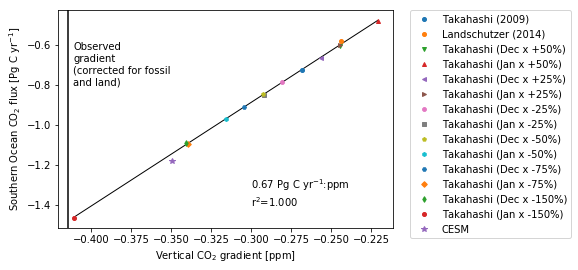

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
wJ = 0.7
wF = 0.0
wD = 0.3

flux_weight = lambda da: (da.sel(time=slice('2015-12-01','2016-02-28')).groupby('time.month').mean()*np.array((wJ,wF,wD))).sum()

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', 'h', 'H', 'D', 'd')
x = np.array([])
y = np.array([])
i = 0
for v in co2_ocn:
    if 'CO2_OCN' in v: continue
    xi = vg_mdl[v]
    yi = flux_weight(sfint[v])
    x = np.append(x,xi)
    y = np.append(y,yi)    
    if 'T09' in v: 
        marker = filled_markers[i]
        i += 1
        if i == len(filled_markers): i = 0
    else:
        marker = filled_markers[0]
    ax.plot(xi,yi,'.',label=ds[v].long_name,marker=marker,markersize=4)

    
ax.plot(vg_mdl.CO2_OCN,flux_weight(sfint.CO2_OCN),'*',markersize=6,label='CESM')


handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())
s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k',zorder=-10)    

ax.axvline(vg_obs.CO2_NOAA-vg_mdl.CO2_FFF-vg_mdl.CO2_LND,color='k')
ax.text(vg_obs.CO2_NOAA-vg_mdl.CO2_FFF-vg_mdl.CO2_LND+0.003,-0.8,'Observed\ngradient\n(corrected for fossil\nand land)')

ax.text(-0.3,-1.4,'{0:0.2f} Pg C yr$^{{-1}}$:ppm\nr$^2$={1:0.3f}'.format(fitted.params[0],fitted.rsquared))

ax.set_xlabel('Vertical CO$_2$ gradient [ppm]')
ax.set_ylabel('Southern Ocean CO$_2$ flux [Pg C yr$^{-1}$]')
plt.savefig(os.path.join(diro['fig'],'calibrate-vertical-gradient-orcas.pdf'),bbox_extra_artists=(lgd,),bbox_inches='tight')

[0.51771795 4.45914684]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1602.
Date:                Mon, 12 Feb 2018   Prob (F-statistic):           2.13e-67
Time:                        13:38:00   Log-Likelihood:                 148.80
No. Observations:                 112   AIC:                            -293.6
Df Residuals:                     110   BIC:                            -288.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5177      0

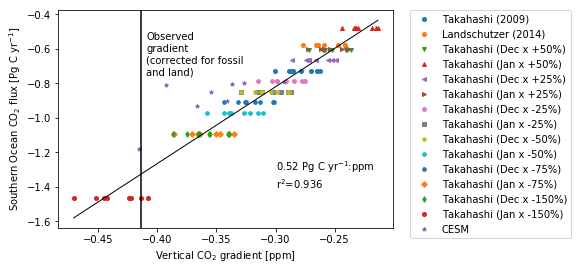

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
#wJ = 0.65
#wF = 0.0
#wD = 0.35

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', 'h', 'H', 'D', 'd')
x = np.array([])
y = np.array([])
i = 0
for v in co2_ocn:
    xi = np.array([])
    yi = np.array([])
    for yr in range(2008,2016):
        vg_window = slice('%d-01-15'%(yr+1),'%d-03-01'%(yr+1))
        sfint_window = slice('%d-12-01'%yr,'%d-02-28'%(yr+1))
        xii = vg[v].sel(time=vg_window).mean()        
        yii = (sfint[v].sel(time=sfint_window).groupby('time.month').mean()*np.array((wJ,wF,wD))).sum()
        xi = np.append(xi,xii)
        yi = np.append(yi,yii)
    if 'CO2_OCN' not in v:
        x = np.append(x,xi)
        y = np.append(y,yi)    
    if 'T09' in v: 
        marker = filled_markers[i]
        i += 1
        if i == len(filled_markers): i = 0
    elif v == 'CO2_OCN':
        marker = '*'
    else:
        marker = filled_markers[0]
    ax.plot(xi,yi,'.',label=ds[v].long_name,marker=marker,markersize=4)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

model = sm.OLS(y, sm.add_constant(x))
fitted = model.fit()

xhat = np.linspace(x.min(),x.max(),50)
yhat = fitted.predict(sm.add_constant(xhat))
yerr = y - fitted.predict(sm.add_constant(x))
xbar = np.mean(x)
n = len(x)
df = n - fitted.df_model - 1
t = stats.t.ppf(1.-0.025,df=df)

print(fitted.params)
print(fitted.summary())
s_err = np.sum(np.power(yerr,2))
ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xhat-xbar),2) / 
((np.sum(np.power(xhat,2))) - n*(np.power(xbar,2))))))

ax.plot(xhat,yhat,'-',linewidth=1,color='k')    

ax.axvline(vg_obs.CO2_NOAA-vg_mdl.CO2_FFF-vg_mdl.CO2_LND,color='k')
ax.text(vg_obs.CO2_NOAA-vg_mdl.CO2_FFF-vg_mdl.CO2_LND+0.005,-0.75,'Observed\ngradient\n(corrected for fossil\nand land)')

ax.text(-0.3,-1.4,'{0:0.2f} Pg C yr$^{{-1}}$:ppm\nr$^2$={1:0.3f}'.format(fitted.params[0],fitted.rsquared))

ax.set_xlabel('Vertical CO$_2$ gradient [ppm]')
ax.set_ylabel('Southern Ocean CO$_2$ flux [Pg C yr$^{-1}$]')
plt.savefig(os.path.join(diro['fig'],'calibrate-vertical-gradient-za-iav.pdf'),bbox_extra_artists=(lgd,),bbox_inches='tight')

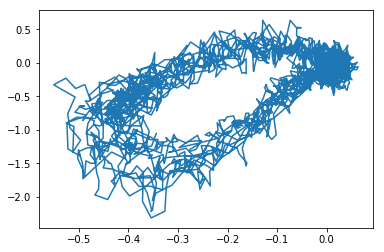

In [13]:
plt.plot(vg.CO2_OCN,sfint.CO2_OCN)

In [14]:
vgmon = vg.groupby('time.month').mean()
sfintmon = sfint.groupby('time.month').mean()
vgmon

<xarray.Dataset>
Dimensions:     (month: 12)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    O2_OCN      (month) float64 13.19 12.69 7.26 1.13 -2.431 -4.902 -6.372 ...
    CO2_CROF    (month) float64 -0.2812 -0.3331 -0.3275 -0.265 -0.2027 ...
    CO2_LND     (month) float64 0.06487 0.05257 0.009671 -0.0218 -0.0318 ...
    CO2_T09     (month) float64 -0.2442 -0.2934 -0.2565 -0.1764 -0.1229 ...
    CO2_T09a    (month) float64 -0.1996 -0.2716 -0.2456 -0.171 -0.12 ...
    CO2_T09b    (month) float64 -0.2004 -0.2436 -0.2347 -0.1668 -0.1182 ...
    CO2_T09c    (month) float64 -0.2219 -0.2825 -0.2511 -0.1737 -0.1215 ...
    CO2_T09d    (month) float64 -0.2223 -0.2685 -0.2456 -0.1716 -0.1205 ...
    CO2_T09e    (month) float64 -0.2665 -0.3043 -0.262 -0.1791 -0.1244 ...
    CO2_T09f    (month) float64 -0.2661 -0.3183 -0.2674 -0.1812 -0.1253 ...
    CO2_T09g    (month) float64 -0.2888 -0.3152 -0.2675 -0.1818 -0.1258 ...
    CO2_T09h    (month) float64 -0

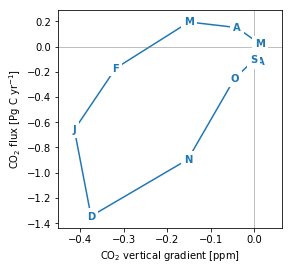

In [15]:
nx = np.concatenate(([-1],np.arange(0,12)))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(vgmon.CO2_OCN,sfintmon.CO2_OCN,marker='o',facecolors='none',edgecolors='none')
p = ax.plot(vgmon.CO2_OCN[nx],sfintmon.CO2_OCN[nx],'-')

for i in range(12):
    t = ax.text(vgmon.CO2_OCN[i],sfintmon.CO2_OCN[i],xcal.month_letter[i],
                verticalalignment='center',
                horizontalalignment='center',
                fontweight='bold',
                color=p[0].get_color(),
                bbox=dict(boxstyle='square,pad=0.3',fc='white',ec='none'))

ax.axhline(0.,color='gray',linewidth=0.5)
ax.axvline(0.,color='gray',linewidth=0.5)

ax.set_xlabel('CO$_2$ vertical gradient [ppm]')
ax.set_ylabel('CO$_2$ flux [Pg C yr$^{-1}$]')
plt.savefig(os.path.join(diro['fig'],'flux-vertical-gradient-climatological-phase-space'))

Plot the regionally integrated flux against the vertical gradient.  The flux is a weighted mean of the Dec, Jan, Feb fluxes (with weights possibly = 0)

In [16]:
fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1602.
Date:                Mon, 12 Feb 2018   Prob (F-statistic):           2.13e-67
Time:                        13:34:24   Log-Likelihood:                 148.80
No. Observations:                 112   AIC:                            -293.6
Df Residuals:                     110   BIC:                            -288.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5177      0.034     15.082      0.000       0.450       0.586
x1             4.4591      0.111     40.024      0.000       4.238       4.680
==============================================================================
Omnibus:                        3.508   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.119
Skew:                          -0.078   Prob(JB):                        0.347
Kurtosis:                       2.344   Cond. No.                         19.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""